# Proyecto Final Parte II: Clasificación-ensambles y presentación ejecutiva

![Logo Tec](img/LogoTec2.jpg)

## Ciencia y analítica de datos (Gpo 10)
### Alumnos: 
* Armando Bringas Corpus (A01200230), 
* Walter André Hauri Rosales (A01794237)

### Profesores: 
* Dra. María de la Paz Rico Fernández
* Mtra. Victoria Guerrero Orozco

### Fecha: 18 de noviembre de 2022

In [66]:
try:
    from jupyterthemes import jtplot
    jtplot.style(theme='monokai', context ='notebook', ticks =True, grid =False) 
except ImportError as error:
   print('Not running in a Jupyter Notebook')

Not running in a Jupyter Notebook


In [67]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, PrecisionRecallDisplay, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import RepeatedStratifiedKFold

In [68]:
data = pd.read_csv("data/Datos_de_calidad_del_agua_de_sitios_de_monitoreo_de_aguas_superficiales_2020_limpio.csv", index_col=0)
data.head()

,CLAVE,SITIO,ORGANISMO_DE_CUENCA,ESTADO,MUNICIPIO,CUENCA,CUERPO DE AGUA,TIPO,SUBTIPO,LONGITUD,...,CONTAMINANTES,CUMPLE_CON_DBO,CUMPLE_CON_DQO,CUMPLE_CON_SST,CUMPLE_CON_CF,CUMPLE_CON_E_COLI,CUMPLE_CON_ENTEROC,CUMPLE_CON_OD,CUMPLE_CON_TOX,GRUPO
0,DLAGU8,PRESA EL SAUCILLO 100M AGUAS ARRIBA DE LA CORTINA,LERMA SANTIAGO PACIFICO,AGUASCALIENTES,RINCON DE ROMOS,RIO SAN PEDRO,PRESA EL SAUCILLO,LENTICO,PRESA,-102.33911,...,"DQO,CF,",SI,NO,SI,NO,SI,ND,SI,SI,LENTICO
1,DLBAJ100,"LOS CABOS SEG 22, 2 ISA10B",PENINSULA DE BAJA CALIFORNIA,BAJA CALIFORNIA SUR,LOS CABOS,SAN JOSE DEL CABO,OCEANO PACIFICO,COSTERO,OCEANO-MAR,-109.84290,...,Desconocido,ND,ND,SI,ND,ND,SI,SI,SI,COSTERO
2,DLBAJ101,"LOS CABOS SEG 22, 1 ISA10B",PENINSULA DE BAJA CALIFORNIA,BAJA CALIFORNIA SUR,LOS CABOS,SAN LUCAS,OCEANO PACIFICO,COSTERO,OCEANO-MAR,-109.86442,...,Desconocido,ND,ND,SI,ND,ND,SI,SI,SI,COSTERO
3,DLBAJ102,LOS CABOS 3,PENINSULA DE BAJA CALIFORNIA,BAJA CALIFORNIA SUR,LOS CABOS,SAN LUCAS,BAHIA SAN LUCAS,COSTERO,BAHIA,-109.88604,...,Desconocido,ND,ND,SI,ND,ND,SI,SI,SI,COSTERO
4,DLBAJ103,LOS CABOS 1,PENINSULA DE BAJA CALIFORNIA,BAJA CALIFORNIA SUR,LOS CABOS,SAN LUCAS,BAHIA SAN LUCAS,COSTERO,BAHIA,-109.89657,...,Desconocido,ND,ND,SI,ND,ND,SI,SI,SI,COSTERO


### Selecciona tus variables independientes X y dependiente Y (semáforo)

In [69]:
y = data["SEMAFORO"]
X = data.drop(columns=["SEMAFORO"])

In [70]:
X = X.select_dtypes(["float64"])

Cambia a label encoding el semáforo, ej, de ["clase 1", "clase 2", "clase 3"] a [ 1,2,3]

In [71]:
colores_semaforo = {'Amarillo': 0, 'Rojo': 1, 'Verde': 2}
y.unique() # Desde la limpieza se convritió a variable categórica

array([1, 2, 0], dtype=int64)

Realiza un análisis general de las features importances a traves de decision trees o random forest.

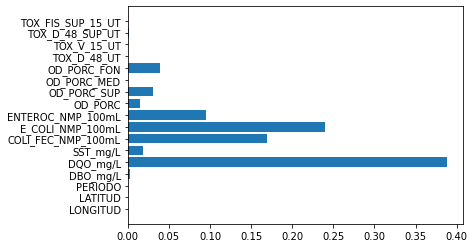

In [72]:
modelo_DT = DecisionTreeClassifier()
clf = modelo_DT.fit(X, y)

plt.barh(X.columns, width = clf.feature_importances_);

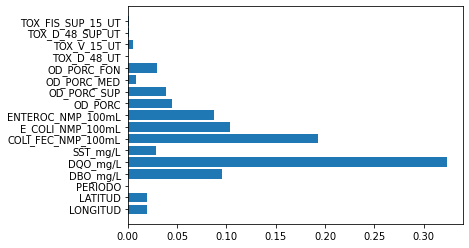

In [73]:
modelo_RF = RandomForestClassifier()
clf = modelo_RF.fit(X, y)

plt.barh(X.columns, width = clf.feature_importances_);

Selecciona las variables de mayor importancia

In [74]:
## TODO

Realiza tu clasificador, recuerda dividir los datos de manera balanceada (auxiliate de train test split)

In [75]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=45, stratify=y)

Explora que clasificador es el más optimo.

Determina el grado de exactitud a través del reporte de clasificación y análisis de la gráfica de Precision Recall.

#### Random forest

In [76]:
mi_modelo_RF = RandomForestClassifier(random_state=45)
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=45) # k-folds cross-validation

dicc_grid = {'ccp_alpha':[0.0, 0.0001, 0.001, 0.01, 0.1],
             'criterion': ["gini", "entropy", "log_loss"],
             'max_depth':range(1,21,2),
             'min_samples_split':range(2, 12, 2),
            }

grid = GridSearchCV(estimator=mi_modelo_RF, param_grid=dicc_grid, cv=cv, scoring="accuracy", n_jobs=-1)

grid.fit(X_train, np.ravel(y_train))

print('Mejor valor de accuracy obtenido con la mejor combinación:', grid.best_score_)
print('Mejor combinación de valores encontrados de los hiperparámetros:', grid.best_params_)
print('Métrica utilizada:', grid.scoring)

Mejor valor de accuracy obtenido con la mejor combinación: 0.9853268872773749
Mejor combinación de valores encontrados de los hiperparámetros: {'ccp_alpha': 0.0, 'criterion': 'gini', 'max_depth': 19, 'min_samples_split': 2}
Métrica utilizada: accuracy


              precision    recall  f1-score   support

    Amarillo       0.99      0.99      0.99       227
        Rojo       1.00      1.00      1.00       218
       Verde       0.99      0.99      0.99       254

    accuracy                           0.99       699
   macro avg       0.99      0.99      0.99       699
weighted avg       0.99      0.99      0.99       699



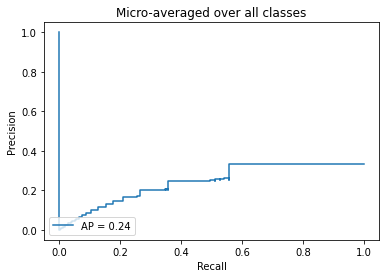

In [77]:
mejor_RF = grid.best_estimator_
y_hat = mejor_RF.predict(X_test)

## Metrics report
print(classification_report(y_test, y_hat, target_names=colores_semaforo))

## Precision-recall plot
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.preprocessing import label_binarize

y_test_bin = label_binarize(y_test, classes=y.unique())
y_score = mejor_RF.predict_proba(X_test)

# For each class
precision = dict()
recall = dict()
average_precision = dict()
n_classes = y_train.unique().shape[0]
for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(y_test_bin[:, i], y_score[:, i])
    average_precision[i] = average_precision_score(y_test_bin[:, i], y_score[:, i])

# A "micro-average": quantifying score on all classes jointly
precision["micro"], recall["micro"], _ = precision_recall_curve(
    y_test_bin.ravel(), y_score.ravel()
)
average_precision["micro"] = average_precision_score(y_test_bin, y_score, average="micro")
display = PrecisionRecallDisplay(
    recall=recall["micro"],
    precision=precision["micro"],
    average_precision=average_precision["micro"],
)
display.plot()
_ = display.ax_.set_title("Micro-averaged over all classes")

#### Decision Tree

In [78]:
mi_modelo_RF = DecisionTreeClassifier(random_state=45)
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=45) # k-folds cross-validation

dicc_grid = {'ccp_alpha':[0.0, 0.0001, 0.001, 0.01, 0.1],
             'criterion': ["gini", "entropy", "log_loss"],
             'max_depth':range(1,21,2),
             'min_samples_split':range(2, 12, 2),
             'class_weight':[None,'balanced'],
            }

grid = GridSearchCV(estimator=mi_modelo_RF, param_grid=dicc_grid, cv=cv, scoring="accuracy", n_jobs=-1)

grid.fit(X_train, np.ravel(y_train))

print('Mejor valor de accuracy obtenido con la mejor combinación:', grid.best_score_)
print('Mejor combinación de valores encontrados de los hiperparámetros:', grid.best_params_)
print('Métrica utilizada:', grid.scoring)

Mejor valor de accuracy obtenido con la mejor combinación: 0.9923647578561305
Mejor combinación de valores encontrados de los hiperparámetros: {'ccp_alpha': 0.0, 'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 13, 'min_samples_split': 8}
Métrica utilizada: accuracy


              precision    recall  f1-score   support

    Amarillo       1.00      1.00      1.00       227
        Rojo       1.00      1.00      1.00       218
       Verde       1.00      1.00      1.00       254

    accuracy                           1.00       699
   macro avg       1.00      1.00      1.00       699
weighted avg       1.00      1.00      1.00       699



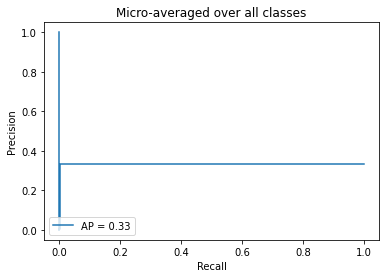

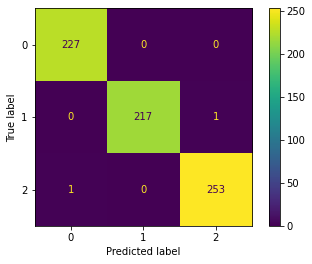

In [79]:
mejor_DT = grid.best_estimator_
y_hat = mejor_DT.predict(X_test)

## Metrics report
print(classification_report(y_test, y_hat, target_names=colores_semaforo))

## Precision-recall plot
y_score = mejor_DT.predict_proba(X_test)

# For each class
precision = dict()
recall = dict()
average_precision = dict()
n_classes = y_train.unique().shape[0]
for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(y_test_bin[:, i], y_score[:, i])
    average_precision[i] = average_precision_score(y_test_bin[:, i], y_score[:, i])

# A "micro-average": quantifying score on all classes jointly
precision["micro"], recall["micro"], _ = precision_recall_curve(
    y_test_bin.ravel(), y_score.ravel()
)
average_precision["micro"] = average_precision_score(y_test_bin, y_score, average="micro")
display = PrecisionRecallDisplay(
    recall=recall["micro"],
    precision=precision["micro"],
    average_precision=average_precision["micro"],
)
display.plot()
_ = display.ax_.set_title("Micro-averaged over all classes")

## Confusion matrix
cf_matrix = confusion_matrix(y_test, y_hat)
ConfusionMatrixDisplay.from_predictions(y_test, y_hat);

Visualiza los resultados del modelo o las predicciones a través de una matriz de confusión

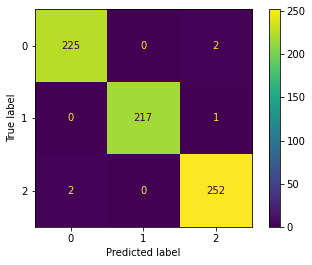

In [80]:
## Confusion matrix
y_hat = mejor_RF.predict(X_test)
cf_matrix = confusion_matrix(y_test, y_hat)
ConfusionMatrixDisplay.from_predictions(y_test, y_hat);

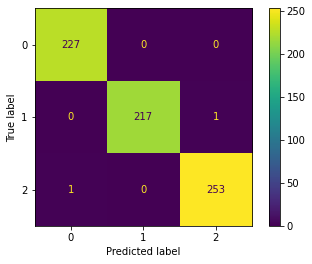

In [81]:
y_hat = mejor_DT.predict(X_test)
cf_matrix = confusion_matrix(y_test, y_hat)
ConfusionMatrixDisplay.from_predictions(y_test, y_hat);